# Shapely masking Proof of Concept

Problem (As always...): We don't have a clear way of dealing with the cyclic point in longitude. If I recall correctly, even the natural earth shapefiles just use groups of polygons for features that cross the dateline and represent everything.

The code below doesn't solve this yet.

In [155]:
from climate_index_collection.data_loading import load_data_set
from climate_index_collection.reductions import spatial_mask
from climate_index_collection.reductions import (
    polygon2mask,
    polygon_prime_meridian,
)

from matplotlib import pyplot as plt

from shapely.affinity import translate
from shapely.geometry import (
    Point, 
    LineString, 
    Polygon,
)
from shapely.geometry import MultiPolygon
from shapely.ops import split, unary_union

import numpy as np
import xarray as xr

import geopandas as gpd

import pytest
import ipytest
ipytest.autoconfig()


In [18]:
ds_FOCI = load_data_set(data_path="../data/test_data/", data_source_name="FOCI")
sst_mean = ds_FOCI["sea-surface-temperature"].mean("time")

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [3]:
NASS_box_lon_lat = Polygon(
    [(-50, 25), (-15, 25), (-15, 50), (-40, 50), (-40, (25+50)//2), (-50, (25+50)//2)]
)

In [4]:
lon_2d, lat_2d = xr.broadcast(ds_FOCI.coords["lon"], ds_FOCI.coords["lat"])
lon_2d = lon_2d % 360 - 360 * ((lon_2d % 360) > 180)

In [5]:
mask = xr.DataArray(
    np.reshape(
        [
            NASS_box_lon_lat.contains(Point(_lon, _lat))
            for _lon, _lat in zip(np.ravel(lon_2d), np.ravel(lat_2d))
        ],
        lon_2d.shape,
    ),
    dims=lon_2d.dims,
    coords=lon_2d.coords,
)

In [6]:
mask.sum()

<xarray.DataArray ()>
array(217)
Coordinates:
    plev     float64 5e+04

In [7]:
NASS_box_lon_lat.contains(Point(-50, 30))

False

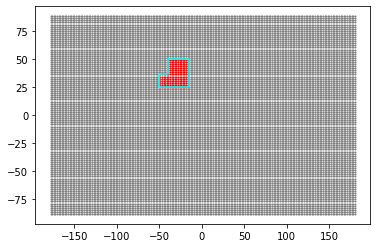

In [8]:
plt.scatter(lon_2d.where(mask), lat_2d.where(mask), s=1, c="r")
plt.scatter(lon_2d.where(~mask), lat_2d.where(~mask), s=1, c="gray")
plt.plot(*NASS_box_lon_lat.exterior.xy, "cyan")

### Getting North Atlantic propely selected
It might make sense to use the area defined by the IPCC
- https://doi.org/10.5194/essd-12-2959-2020
- https://github.com/SantanderMetGroup/ATLAS

https://github.com/SantanderMetGroup/ATLAS/blob/main/reference-regions/IPCC-WGI-reference-regions-v4_shapefile.zip


In [9]:
"""
this all is based on 
https://gis.stackexchange.com/questions/113799/reading-shapefile-in-python
https://gis.stackexchange.com/questions/113799/reading-shapefile-in-python
"""
shapefile = gpd.read_file("IPCC-WGI-reference-regions-v4.shp", SHAPE_RESTORE_SHX = "yes")
NAO_polygon = shapefile["geometry"][50]
EAO_polygon = shapefile["geometry"][51]

In [10]:
mask_NAO = xr.DataArray(
    np.reshape(
        [
            NAO_polygon.contains(Point(_lon, _lat))
            for _lon, _lat in zip(np.ravel(lon_2d), np.ravel(lat_2d))
        ],
        lon_2d.shape,
    ),
    dims=lon_2d.dims,
    coords=lon_2d.coords,
)
mask_EAO = xr.DataArray(
    np.reshape(
        [
            EAO_polygon.contains(Point(_lon, _lat))
            for _lon, _lat in zip(np.ravel(lon_2d), np.ravel(lat_2d))
        ],
        lon_2d.shape,
    ),
    dims=lon_2d.dims,
    coords=lon_2d.coords,
)

mask_Atlantik = (mask_EAO | mask_NAO) & spatial_mask(
    sst_mean,
    lat_north = 70,
    lat_south = 0,
    lon_west = -90,
    lon_east = 15)

prime_meridian = LineString([(0,90), (0,-90)])

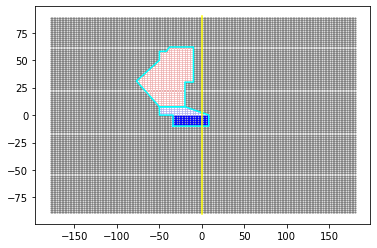

In [11]:
plt.scatter(lon_2d, lat_2d, s=1, c="gray")
plt.scatter(lon_2d.where(mask_NAO), lat_2d.where(mask_NAO), s=1, c="r")
plt.plot(*NAO_polygon.exterior.xy, "cyan")
plt.scatter(lon_2d.where(mask_EAO), lat_2d.where(mask_EAO), s=1, c="b")
plt.plot(*EAO_polygon.exterior.xy, "cyan")
plt.scatter(lon_2d.where(mask_Atlantik), lat_2d.where(mask_Atlantik), s=1, c="w")
plt.plot(*prime_meridian.xy, "yellow")


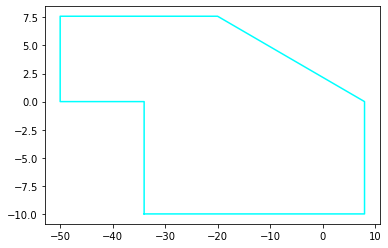

In [12]:
plt.plot(*EAO_polygon.exterior.xy, "cyan")

### Lets try to split these polygons

In [13]:
lon_2d_360, lat_2d_360 = xr.broadcast(ds_FOCI.coords["lon"], ds_FOCI.coords["lat"])

splitted_EAO_polgon = split(EAO_polygon, prime_meridian)
EAO_west = translate(splitted_EAO_polgon.geoms[0], xoff=360)
EAO_east = splitted_EAO_polgon.geoms[1]

mask_EAO_split = xr.DataArray(
    np.reshape(
        [
            EAO_west.contains(Point(_lon, _lat)) |
            EAO_east.contains(Point(_lon, _lat)) 
            for _lon, _lat in zip(np.ravel(lon_2d_360), np.ravel(lat_2d_360))
        ],
        lon_2d_360.shape,
    ),
    dims=lon_2d_360.dims,
    coords=lon_2d_360.coords,
)

In [14]:
len(splitted_EAO_polgon.geoms)

2

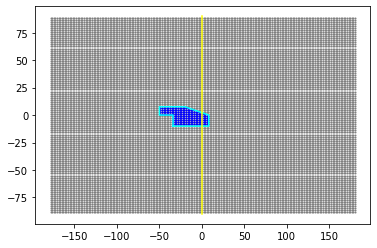

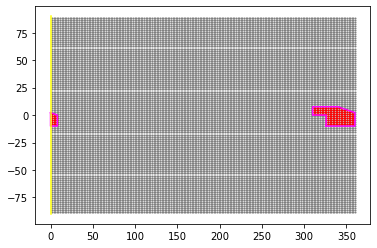

In [15]:

plt.scatter(lon_2d, lat_2d, s=1, c="gray")
plt.scatter(lon_2d.where(mask_EAO), lat_2d.where(mask_EAO), s=1, c="b")
plt.plot(*EAO_polygon.exterior.xy, "cyan")
plt.plot(*prime_meridian.xy, "yellow")
plt.figure()
plt.scatter(lon_2d + 180, lat_2d, s=1, c="gray")
plt.plot(*EAO_west.exterior.xy, "magenta")
plt.plot(*EAO_east.exterior.xy, "magenta")
plt.scatter(lon_2d_360.where(mask_EAO_split), lat_2d_360.where(mask_EAO_split), s=1, c="r")
plt.plot(*prime_meridian.xy, "yellow")


## Using unary_union to make things easier in the mask creation

<class 'shapely.geometry.multipolygon.MultiPolygon'>


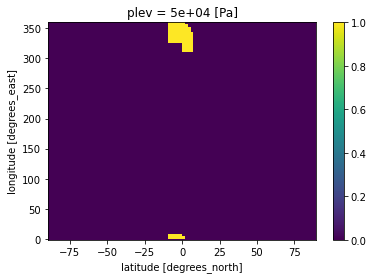

In [16]:
EAO_split = unary_union([EAO_east, EAO_west])
print(type(EAO_split))
mask_EAO_split_union = xr.DataArray(
    np.reshape(
        [
            EAO_split.contains(Point(_lon, _lat))
            for _lon, _lat in zip(np.ravel(lon_2d_360), np.ravel(lat_2d_360))
        ],
        lon_2d_360.shape,
    ),
    dims=lon_2d_360.dims,
    coords=lon_2d_360.coords,
)
mask_EAO_split_union.plot()

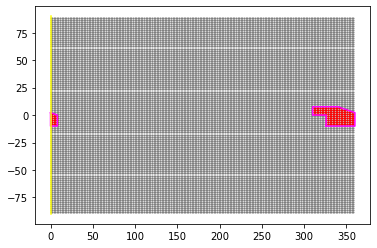

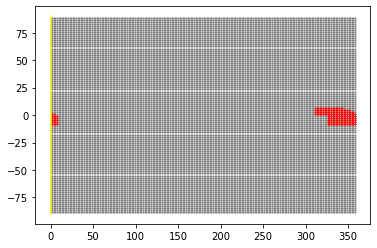

In [17]:
plt.scatter(lon_2d_360, lat_2d_360, s=1, c="gray")
plt.plot(*EAO_west.exterior.xy, "magenta")
plt.plot(*EAO_east.exterior.xy, "magenta")
plt.scatter(lon_2d_360.where(mask_EAO_split), lat_2d_360.where(mask_EAO_split), s=1, c="r")
plt.plot(*prime_meridian.xy, "yellow")

plt.figure()
plt.scatter(lon_2d_360, lat_2d_360, s=1, c="gray")
# plt.plot(*EAO_split.exterior.xy, "magenta")
plt.scatter(lon_2d_360.where(mask_EAO_split_union), lat_2d_360.where(mask_EAO_split_union), s=1, c="r")
plt.plot(*prime_meridian.xy, "yellow")


### Two functions should be enough to support this:

### The procedure is as follows:
1. Using multiple polygons from shapely and the differenct set theories to create a multiploygon.
2. Pass the multipolygon to polygon_prime_meridian to change coordiante system
3. pass the result from 2. to polygon2mask to create the mask corresponding to the lon, lat grid. 

In [19]:
#1. 
atlantic_big = Polygon([(-90,0), (-90, 70), (20,70), (20, 0)])
pg = unary_union([NAO_polygon, EAO_polygon])
pg = pg.intersection(atlantic_big)
#2. 
atlantic_pg = polygon_prime_meridian(pg)
#3. 
atlantic_mask = polygon2mask(sst_mean, atlantic_pg)

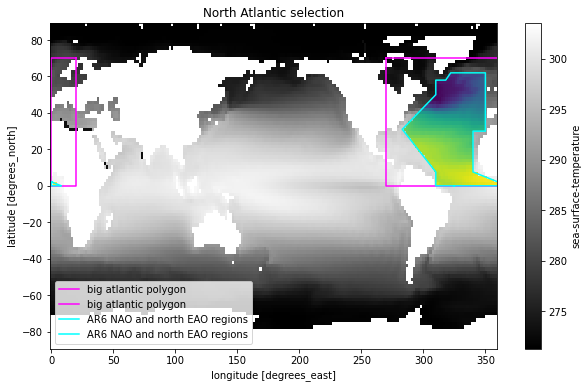

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))
sst_mean.plot(ax = ax, cmap = "gray")
sst_mean.where(atlantic_mask).plot(ax = ax, add_colorbar=False)

for temp_pg in polygon_prime_meridian(atlantic_big).geoms :
    ax.plot(*temp_pg.exterior.xy, color = "magenta", label = "big atlantic polygon")
for temp_pg in polygon_prime_meridian(atlantic_pg).geoms :
    ax.plot(*temp_pg.exterior.xy, color = "cyan", label = "AR6 NAO and north EAO regions")
ax.legend()
ax.set_title("North Atlantic selection")
fig.savefig("AtlanticMaskSelection.png")

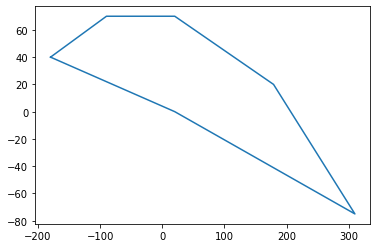

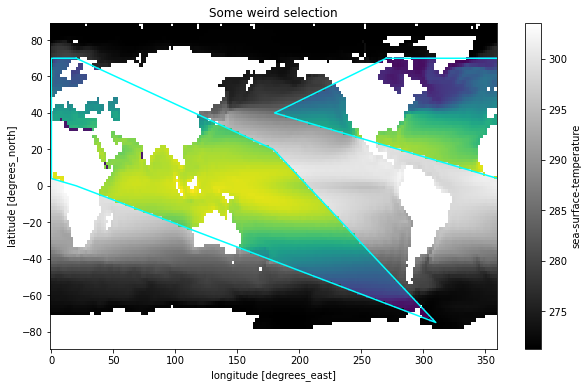

In [34]:
weird_polygon = Polygon([(-180,40), (-90, 70), (20,70), (179, 20), (310, -75), (20, 0)])

plt.plot(*weird_polygon.exterior.xy)
plt.savefig("WeirdPolygon.png")
weird_mask = polygon2mask(sst_mean, polygon_prime_meridian(weird_polygon))

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))
sst_mean.plot(ax = ax, cmap = "gray")
sst_mean.where(weird_mask).plot(ax = ax, add_colorbar=False)

for temp_pg in polygon_prime_meridian(weird_polygon).geoms :
    ax.plot(*temp_pg.exterior.xy, color = "cyan")
ax.set_title("Some weird selection")
fig.savefig("WeirdSelection.png")

### Lets test natural earth shp file

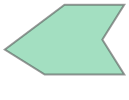

In [173]:
atlantic = Polygon([
    (15, 0),
    (-65, 0),
    (-105, 25),
    (-45, 70),
    (15, 70),
    (-7, 35)
])
atlantic

Text(0.5, 1.0, 'North Atlantic selection')

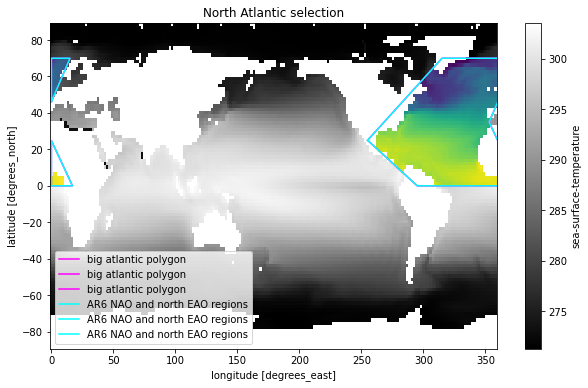

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6))
sst_mean.plot(ax = ax, cmap = "gray")
sst_mean.where(polygon2mask(sst_mean, atlantic)).plot(ax = ax, add_colorbar=False)

for temp_pg in polygon_prime_meridian(atlantic).geoms :
    ax.plot(*temp_pg.exterior.xy, color = "magenta", label = "big atlantic polygon")
for temp_pg in polygon_prime_meridian(atlantic).geoms :
    ax.plot(*temp_pg.exterior.xy, color = "cyan", label = "AR6 NAO and north EAO regions")
ax.legend()
ax.set_title("North Atlantic selection")

## Testing

In [157]:

def test_polygon_prime_meridian_whole_earth():
    pg = Polygon([
        (-180, 90),
        (180, 90),
        (180, -90),
        (-180, -90)
    ])
    pg_new = polygon_prime_meridian(pg)
    assert pg.area = pg_new.area

def test_polygon_prime_meridian_across_dateline():
    assert 
    
def test_polygon2mask_across_dateline():
    """Check case where lon W/E bounds are ordered in interval [0,360)."""
    data_set = xr.Dataset(
        coords={
            "lat": [
                0.0,
            ],
            "lon": [
                0.0,
                120.0,
                240.0,
            ],
        }
    )
    pg = Polygon([
        (30, 90),
        (270, 90),
        (270, -90),
        (30, -90)
    ])
    mask = polygon2mask(data_set, pg)
    assert mask.astype(int).sum().data[()] == 2
    assert all(m == mt for m, mt in zip([False, True, True], mask.squeeze().data))


def test_polygon2mask_across_zero_meridian():
    """Check case where lon W/E bounds are ordered in interval [-180, 180)."""
    data_set = xr.Dataset(
        coords={
            "lat": [
                0.0,
            ],
            "lon": [
                0.0,
                120.0,
                240.0,
            ],
        }
    )
    pg = Polygon([
        (30, 90),
        (-180, 90),
        (-180, -90),
        (30, -90)
    ])
    mask = polygon2mask(data_set, pg)
    assert mask.astype(int).sum().data[()] == 2
    assert all(m == mt for m, mt in zip([True, False, True], mask.squeeze().data))

def test_polygon2mask_point_on_boundary():
    """Check case where a point lies on the boundary of the polygon.
    Here it is the Point (0, 0) is situated on the boundary."""
    data_set = xr.Dataset(
        coords={
            "lat": [
                0.0,
                -10.0,
            ],
            "lon": [
                0.0,
                120.0,
                240.0,
            ],
        }
    )
    pg = Polygon([
        (0, 0),
        (5, 0),
        (5, 5),
        (0, 5)
    ])

    mask = polygon2mask(data_set, pg)
    
    mask_should = np.array([
        [True,  False, False], 
        [False, False, False]
    ])
        
    assert mask.astype(int).sum().data[()] == 1
    assert all(m == mt for m, mt in zip(
        mask_should.flatten(),
        mask.data.flatten())
              )

def test_polygon2mask_multipolygon():
    """Check case where a point lies on the boundary of the polygon.
    Here it is the Point (0, 0) is situated on the boundary."""
    data_set = xr.Dataset(
        coords={
            "lat": [
                0.0,
                -10.0,
            ],
            "lon": [
                0.0,
                120.0,
                240.0,
            ],
        }
    )
    pg1 = Polygon([
        (0, 0),
        (5, 0),
        (5, 5),
        (0, 5)
    ])
    pg2 = Polygon([
        (110, -10),
        (130, -10),
        (130, -15),
        (110, -15)
    ])
    pg = unary_union([pg1, pg2])
    mask = polygon2mask(data_set, pg)
    mask_should = np.array([
        [True,  False, False], 
        [False, True,  False]
    ])
    assert mask.astype(int).sum().data[()] == 2
    assert all(m == mt for m, mt in zip(
                mask_should.flatten(),
                mask.data.flatten())
              )


In [158]:
ipytest.run()

======================================= test session starts ========================================
platform linux -- Python 3.9.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /work, configfile: pyproject.toml
plugins: anyio-3.5.0
collected 5 items

tmpopg2lrsb.py 

64800.0

.....                                                                         [100%]

======================================== 5 passed in 0.17s =========================================


<ExitCode.OK: 0>

In [134]:
ipytest.clean_tests()

def test_polygon_prime_meridian_no_crossing_polygon():
    """
    Check if input 
    - Polygon which 
    - does not cross prime meridian 
    is returned 
    - correct and 
    - has type as MutliPolygon"""
    
    pg = Polygon([
        (10, 50),
        (5, 50),
        (5, -50),
        (10, -50)
    ])
    result = polygon_prime_meridian(pg)
    should_result = Polygon([
        (10, 50),
        (5, 50),
        (5, -50),
        (10, -50)
    ])
    assert result.equals(should_result)
    assert type(result) is MultiPolygon

def test_polygon_prime_meridian_no_crossing_multipolygon():
    """
    Check if input 
    - MultiPolygon which 
    - does not cross prime meridian 
    is returned 
    - correct and 
    - has type as MutliPolygon
    """

    pg = MultiPolygon([
        Polygon([
            (10, 50),
            (5, 50),
            (5, 10),
            (10, 10)
        ]),
        Polygon([
            (10, -10),
            (5, -10),
            (5, -50),
            (5, -50)
        ]),
    ])
    result = polygon_prime_meridian(pg)
    should_result = MultiPolygon([
        Polygon([
            (10, 50),
            (5, 50),
            (5, 10),
            (10, 10)
        ]),
        Polygon([
            (10, -10),
            (5, -10),
            (5, -50),
            (5, -50)
        ]),
    ])
    assert result.equals(should_result)
    assert type(result) is MultiPolygon
    

def test_polygon_prime_meridian_crossing_polygon():
    """
    Check if input 
    - Polygon which 
    - does cross prime meridian 
    is returned 
    - correct and 
    - has type as MutliPolygon
    """

    pg = Polygon([
        (10, 50),
        (-10, 50),
        (-10, -50),
        (10, -50)
    ])
    result = polygon_prime_meridian(pg)
    should_result = unary_union([
        Polygon([
            (360, 50),
            (350, 50),
            (350, -50),
            (360, -50)
        ]),
        Polygon([
            (10, 50),
            (0, 50),
            (0, -50),
            (10, -50)
        ])
    ])
    assert result.equals(should_result)
    assert type(result) is MultiPolygon
    
def test_polygon_prime_meridian_crossing_multipolygon():
    """
    Check if input 
    - MultiPolygon which 
    - does cross prime meridian 
    is returned 
    - correct and 
    - has type as MutliPolygon
    """
    
    pg = MultiPolygon([
        Polygon([
            (10, 50),
            (-10, 50),
            (-10,-50),
            (10, -50)
        ]),
        Polygon([
            (50, -10),
            (180, -10),
            (180, -50),
            (50, -50)
        ]),
    ])
    result = polygon_prime_meridian(pg)
    should_result = MultiPolygon([
        Polygon([
            (10, 50),
            (0, 50),
            (0, -50),
            (10, -50)
        ]),
        Polygon([
            (50, -10),
            (180, -10),
            (180, -50),
            (50, -50)
        ]),
        Polygon([
            (360, 50),
            (350, 50),
            (350, -50),
            (360, -50)
        ]),
    ])
    assert result.equals(should_result)
    assert type(result) is MultiPolygon

def test_polygon_prime_meridian_crossing_multipolygon_overlap():
    """
    Check if input 
    - Polygon which 
    - does cross prime meridian
    - and is defined in coords [180W, 360E)
    is returned 
    - correct and 
    - handles the resulting overlap of the Polygons created by the split and
    - has type as MutliPolygon
    """

    pg = MultiPolygon([
        Polygon([
            (10, 50),
            (-10, 50),
            (-10,-50),
            (10, -50)
        ]),
        Polygon([
            (50, -10),
            (355, -10),
            (355, -50),
            (50, -50)
        ]),
    ])
    result = polygon_prime_meridian(pg)
    should_result = MultiPolygon([
        Polygon([
            (10, 50),
            (0, 50),
            (0, -50),
            (10, -50)
        ]),
        Polygon([
            (360, 50),
            (350, 50),
            (350, -10),
            (50, -10),
            (50, -50),
            (360, -50),
        ])
    ])
    assert result.equals(should_result)
    assert type(result) is MultiPolygon
    
def test_polygon_prime_meridian_whole_earth():
    pg = Polygon([
        (-180, 90),
        (180, 90),
        (180, -90),
        (-180, -90)
    ])
    should_result = Polygon([
        (0,90),
        (360, 90),
        (360, -90),
        (0, -90)
    ])
    result = polygon_prime_meridian(pg)
    assert pg.area == result.area
    assert result.equals(should_result)
    assert type(result) is MultiPolygon


In [135]:
ipytest.run()

======================================= test session starts ========================================
platform linux -- Python 3.9.12, pytest-7.1.2, pluggy-1.0.0
rootdir: /work, configfile: pyproject.toml
plugins: anyio-3.5.0
collected 6 items

tmpwsf9gyqh.py ......                                                                        [100%]

======================================== 6 passed in 0.12s =========================================


<ExitCode.OK: 0>

# Implementation of polygon splitting in abritrary bounds

In [200]:
def polygon_splitting(pg, lon_min, lon_max, max_iteration = 50):
    """
    Transforms shapely Polygons or MultiPolygons defined in [180W, 180E) coords into [0E,360E) coords.
    Takes care of Polygons crossing the prime meridan.
    Polygon points are expected be (lon, lat) tuples.

    Parameters
    ----------
    pg: shaply Polygon or shapely MultiPolygon
        Polygon including the area wanted.
    Returns
    -------
    shapely MultPolygon
        shaply MultiPolygon containing at least one Polygon.
    """
    check_bounds = lambda pg : pg.bounds[0] >= lon_min and pg.bounds[2] <= lon_max

    # handle empty Polygons and MultiPolygons
    if pg.is_empty:
        return MultiPolygon([pg])

    # create cutting meridians at min and max of lon of dobj to eventually split the polygon there.
    left_splitter  = LineString([(lon_min, 90), (lon_min, 0), (lon_min, -90)])
    right_splitter = LineString([(lon_max, 90), (lon_max, 0), (lon_max, -90)])
    
    # handle all polygon parts left of the lon bounaries
    i = 0
    while not pg.bounds[0] >= lon_min and i < max_iteration:
        i += 1
        pg_list = []    
        # while not split_done :
        pg_split = split(pg, left_splitter)
        for temp_pg in pg_split.geoms:
            # check if the polygons minx is negative and add 360 to it.
            if temp_pg.bounds[0] < lon_min:
                temp_pg = translate(temp_pg, xoff=360)
            pg_list += [temp_pg]
        pg = unary_union(pg_list)

    # handle all polygon parts right of the lon bounaries        
    while not pg.bounds[2] <= lon_max and i < max_iteration:
        i += 1
        pg_list = [] 
        pg_split = split(pg, right_splitter)
        for temp_pg in pg_split.geoms:
            # check if the polygons minx is negative and add 360 to it.
            if temp_pg.bounds[2] > lon_max:
                temp_pg = translate(temp_pg, xoff=-360)
            pg_list += [temp_pg]
        pg = unary_union(pg_list)
    
    
    # create the multipolygon existing in [0E, 360E) coords from the list of polygons
    result = pg
    # for consistency always return MultiPolygon
    if type(result) is not MultiPolygon:
        # convert Polygon to MultiPolygon
        return MultiPolygon([result])
    else:
        return result
    # create the multipolygon existing in [0E, 360E) coords from the list of polygons
    result = unary_union(result)


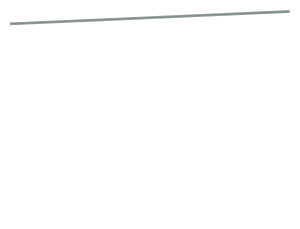

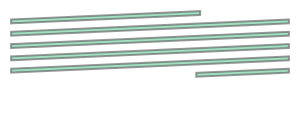

In [203]:
longpolygon = Polygon([
    (60, 0),
    (1865, 80),
    (1865, 85),
    (60, 5),
])
display(longpolygon)
polygon_splitting(longpolygon, lon_min = -180, lon_max = 180)